In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skimage.segmentation import slic
import scipy.ndimage
import scipy.spatial
import torch
from torchvision import datasets
import sys
sys.path.append("../")
from chebygin import ChebyGIN
from extract_superpixels import process_image
from graphdata import comput_adjacency_matrix_images
from train_test import load_save_noise
from utils import list_to_torch, data_to_device, normalize_zero_one

# MNIST-75sp

In [2]:
data_dir = '../data'
checkpoints_dir = '../checkpoints'
device = 'cuda'

# Load images using standard PyTorch Dataset
data = datasets.MNIST(data_dir, train=False, download=True)
images = data.test_data.numpy()
targets = data.test_labels
# mean and std computed for superpixel features
# features are 3 pixel intensities and 2 coordinates (x,y)
# 3 pixel intensities because we replicate mean pixel value 3 times to test on colored MNIST images
mn = torch.tensor([0.11225057, 0.11225057, 0.11225057, 0.44206527, 0.43950436]).view(1, 1, -1)
sd = torch.tensor([0.2721889,  0.2721889,  0.2721889,  0.2987583,  0.30080357]).view(1, 1, -1)

class SuperpixelArgs():
    def __init__(self):
        self.n_sp = 75
        self.compactness = 0.25
        self.split = 'test'
        self.dataset = 'mnist'

img_size = images.shape[1]
noises = load_save_noise('../data/mnist_75sp_noise.pt', (images.shape[0], 75))
color_noises = load_save_noise('../data/mnist_75sp_color_noise.pt', (images.shape[0], 75, 3))
n_images = images.shape[0]

noise_levels = np.array([0.4, 0.6])

loading noise from ../data/mnist_75sp_noise.pt
loading noise from ../data/mnist_75sp_color_noise.pt


In [3]:
def acc(pred):
    return torch.mean((torch.stack(pred) == targets[:len(pred)]).float()).item() * 100

# This function takes a single 28x28 MNIST image, model object, and std of noise added to node features,
# performs all necessary preprocessing (including superpixels extraction) and returns predictions
def test(model, img, index, noise_std, colornoise_std, show_img=False):
    
    sp_intensity, sp_coord, sp_order, superpixels = process_image((img, 0, 0, SuperpixelArgs(), False, False))
    #assert np.
    if show_img:
        sz = img.shape
        plt.figure(figsize=(20,5))
        plt.subplot(141)        
        plt.imshow(img / 255., cmap='gray')
        plt.title('Input MNIST image')
        img_sp = np.zeros((sz[0], sz[1]))
        img_noise = np.zeros((sz[0], sz[1], 3))
        img_color_noise = np.zeros((sz[0], sz[1], 3))    
        for sp_intens, sp_index in zip(sp_intensity, sp_order):
            mask = superpixels == sp_index
            x = (sp_intens - mn[0, 0, 0].item()) / sd[0, 0, 0].item()
            img_sp[mask] = x
            img_noise[mask] = x + noises[index, sp_index] * noise_std
            img_color_noise[mask] = x + color_noises[index, sp_index] * colornoise_std
        plt.subplot(142)
        plt.imshow(normalize_zero_one(img_sp), cmap='gray')
        plt.title('Superpixels of the image')
        plt.subplot(143)
        plt.imshow(normalize_zero_one(img_noise), cmap='gray')
        plt.title('Noisy superpixels')
        plt.subplot(144)
        plt.imshow(normalize_zero_one(img_color_noise))
        plt.title('Noisy and colored superpixels')
        plt.show()
            
    sp_coord = sp_coord / img_size
    N_nodes = sp_intensity.shape[0]
    mask = torch.ones(1, N_nodes, dtype=torch.uint8)
    x = (torch.from_numpy(np.pad(np.concatenate((sp_intensity, sp_coord), axis=1), 
                                ((0, 0), (2, 0)), 'edge')).unsqueeze(0) - mn) / sd    
    A = torch.from_numpy(comput_adjacency_matrix_images(sp_coord)).float().unsqueeze(0)
    y, other_outputs = model(data_to_device([x, A, mask, -1, {'N_nodes': torch.zeros(1, 1) + N_nodes}], 
                                            device))
    y_clean = torch.argmax(y).data.cpu()    
    alpha_clean = other_outputs['alpha'][0].data.cpu() if 'alpha' in other_outputs else []
    
    x_noise = x.clone()
    x_noise[:, :, :3] += noises[index, :N_nodes].unsqueeze(0).unsqueeze(2) * noise_std
    y, other_outputs = model(data_to_device([x_noise, A, mask, -1, {'N_nodes': torch.zeros(1, 1) + N_nodes}], 
                                            device))
    y_noise = torch.argmax(y).data.cpu()
    alpha_noise = other_outputs['alpha'][0].data.cpu() if 'alpha' in other_outputs else []
    
    x_noise = x.clone()
    x_noise[:, :, :3] += color_noises[index, :N_nodes] * colornoise_std
    y, other_outputs = model(data_to_device([x_noise, A, mask, -1, {'N_nodes': torch.zeros(1, 1) + N_nodes}], 
                                            device))
    y_colornoise = torch.argmax(y).data.cpu()
    alpha_color_noise = other_outputs['alpha'][0].data.cpu() if 'alpha' in other_outputs else []
    
    return y_clean, y_noise, y_colornoise, alpha_clean, alpha_noise, alpha_color_noise


# This function returns predictions for the entire clean and noise test sets
def get_predictions(model_path):
    state = torch.load(model_path)
    args = state['args']
    model = ChebyGIN(in_features=5,
                     out_features=10,
                     filters=args.filters,
                     K=args.filter_scale,
                     n_hidden=args.n_hidden,
                     aggregation=args.aggregation,
                     dropout=args.dropout,
                     readout=args.readout,
                     pool=args.pool,
                     pool_arch=args.pool_arch)
    model.load_state_dict(state['state_dict'])
    model = model.eval().to(device)
    #print(model)    

    # Get predictions
    pred, pred_noise, pred_colornoise = [], [], []
    alpha, alpha_noise, alpha_colornoise = [], [], []
    for index, img in enumerate(images):
        y = test(model, img, index, noise_levels[0], noise_levels[1], index == 0)
        pred.append(y[0])
        pred_noise.append(y[1])
        pred_colornoise.append(y[2])  
        alpha.append(y[3])
        alpha_noise.append(y[4])
        alpha_colornoise.append(y[5])
        if len(pred) % 1000 == 0:
            print('{}/{}, acc clean={:.2f}%, acc noise={:.2f}%, acc color noise={:.2f}%'.format(len(pred), 
                                                                                            n_images,
                                                                                            acc(pred), 
                                                                                            acc(pred_noise), 
                                                                                            acc(pred_colornoise)))
    return pred, pred_noise, pred_colornoise, alpha, alpha_noise, alpha_colornoise

## Global pooling model

ChebyGINLayer torch.Size([4, 20]) tensor([0.5876, 0.5882, 0.5687, 0.6337], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.6517, 0.6288, 0.5493, 0.6628, 0.6401, 0.6374, 0.6502, 0.5830, 0.5757,
        0.4468], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([512, 256]) tensor([0.5913, 0.6105, 0.5834, 0.5795, 0.5743, 0.5781, 0.5866, 0.5805, 0.5721,
        0.5827], grad_fn=<SliceBackward>)


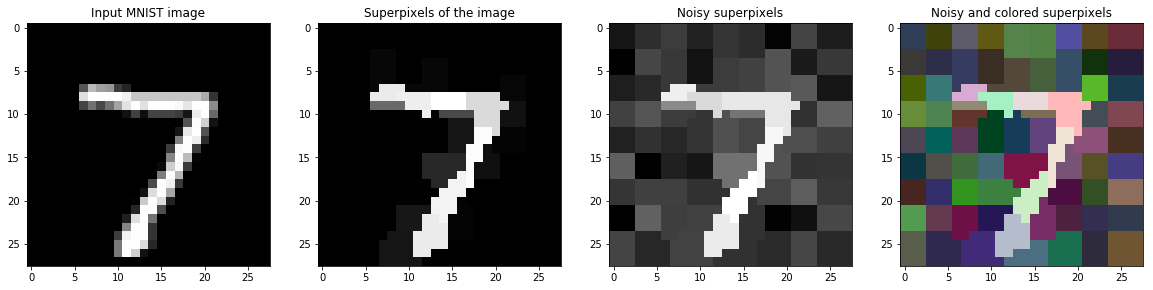

1000/10000, acc clean=97.50%, acc noise=77.80%, acc color noise=85.70%
2000/10000, acc clean=96.85%, acc noise=77.35%, acc color noise=84.50%
3000/10000, acc clean=96.63%, acc noise=77.90%, acc color noise=84.13%
4000/10000, acc clean=96.47%, acc noise=77.80%, acc color noise=83.88%
5000/10000, acc clean=96.48%, acc noise=77.62%, acc color noise=84.12%
6000/10000, acc clean=96.82%, acc noise=79.12%, acc color noise=85.10%
7000/10000, acc clean=97.07%, acc noise=79.50%, acc color noise=85.59%
8000/10000, acc clean=97.35%, acc noise=80.04%, acc color noise=86.02%
9000/10000, acc clean=97.53%, acc noise=80.71%, acc color noise=86.56%
10000/10000, acc clean=97.48%, acc noise=80.51%, acc color noise=86.54%


In [4]:
pred = get_predictions('%s/checkpoint_mnist-75sp_820601_epoch30_seed0000111.pth.tar' % checkpoints_dir)

## Visualize heat maps

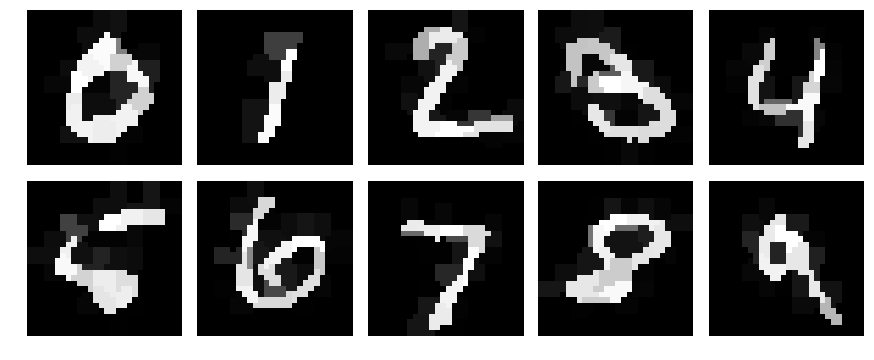

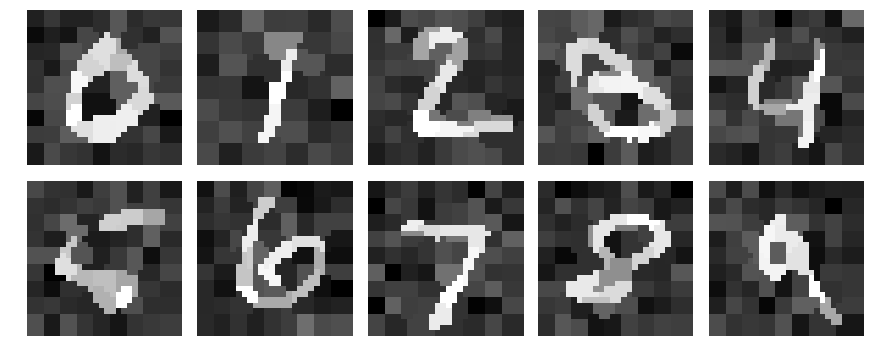

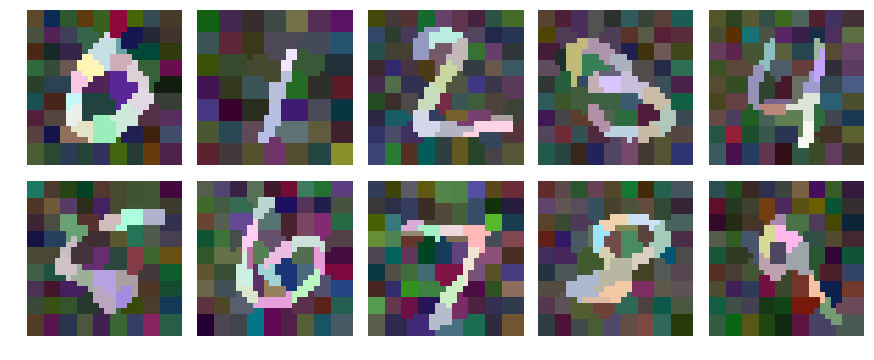

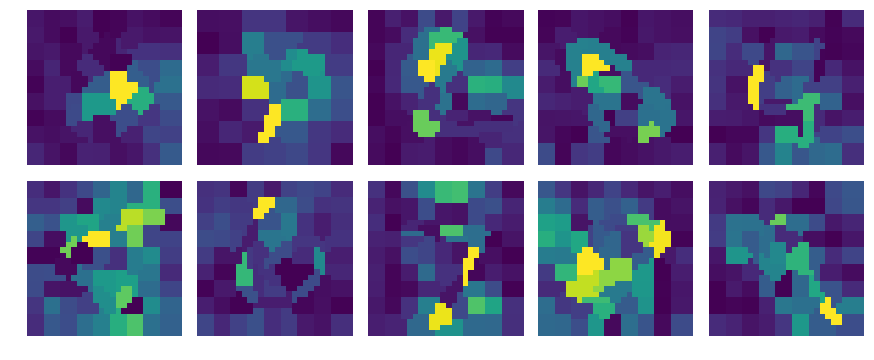

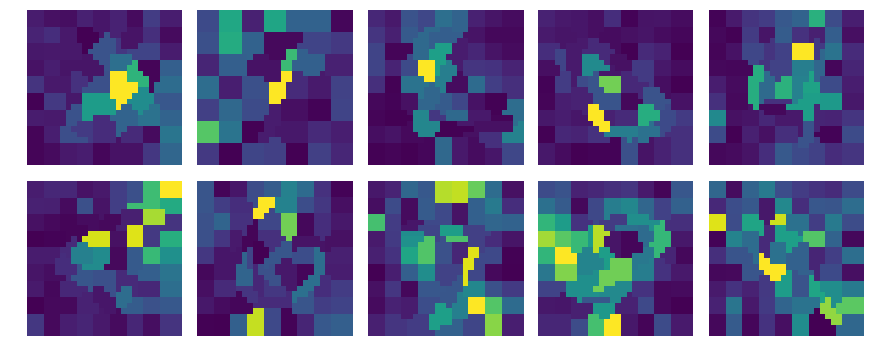

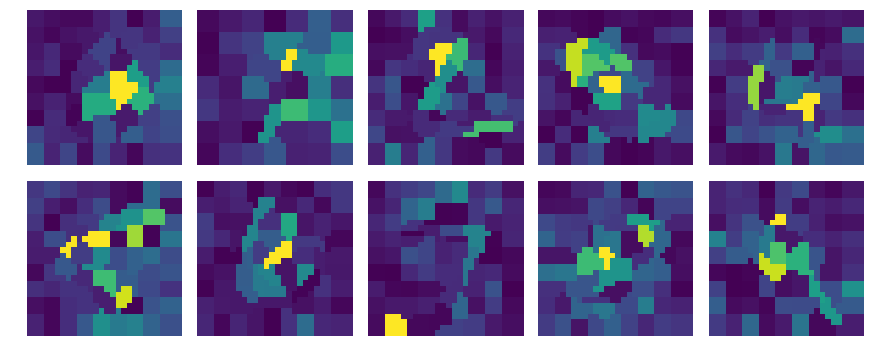

In [5]:
with open('../checkpoints/mnist-75sp_alpha_WS_test_seed111_orig.pkl', 'rb') as f:
    global_pool_attn_orig = pickle.load(f)
    
with open('../checkpoints/mnist-75sp_alpha_WS_test_seed111_noisy.pkl', 'rb') as f:
    global_pool_attn_noise = pickle.load(f)    

with open('../checkpoints/mnist-75sp_alpha_WS_test_seed111_noisy-c.pkl', 'rb') as f:
    global_pool_attn_colornoise = pickle.load(f) 

# Load precomputed superpixels to have the order of superpixels consistent with those in global_pool_attn_orig
with open('../data/mnist_75sp_test.pkl', 'rb') as f:
    test_data = pickle.load(f)[1]
with open('../data/mnist_75sp_test_superpixels.pkl', 'rb') as f:
    test_superpixels = pickle.load(f)
    
# Get ids of the first test sample for labels from 0 to 9
ind = []
labels_added = set()
for i, lbl in enumerate(data.test_labels.numpy()):
    if lbl not in labels_added:
        ind.append(i)
        labels_added.add(lbl)
ind_sorted = []
for i in np.argsort(data.test_labels):
    if i in ind:
        ind_sorted.append(i)

sz = data.test_data.shape

images_sp, images_noise, images_color_noise, images_heat, images_heat_noise, images_heat_noise_color = [], [], [], [], [], []
for i in ind_sorted:
#     sp_intensity, sp_coord, sp_order, superpixels = process_image((images[i], 0, 0, SuperpixelArgs(), False, False))
    sp_intensity, sp_coord, sp_order = test_data[i]
    superpixels = test_superpixels[i]
    n_sp = sp_intensity.shape[0]
    noise, color_noise = noises[i, :n_sp], color_noises[i, :n_sp]    
    img = np.zeros((sz[1], sz[1]))
    img_noise = np.zeros((sz[1], sz[1], 3))
    img_color_noise = np.zeros((sz[1], sz[1], 3))    
    img_heat = np.zeros((sz[1], sz[1]))
    img_heat_noise = np.zeros((sz[1], sz[1]))
    img_heat_noise_color = np.zeros((sz[1], sz[1]))    
    for j, (sp_intens, sp_index) in enumerate(zip(sp_intensity, sp_order)):
        mask = superpixels == sp_index
        x = (sp_intens - mn[0, 0, 0].item()) / sd[0, 0, 0].item()
        img[mask] = x
        img_noise[mask] = x + noise[sp_index] * noise_levels[0]
        img_color_noise[mask] = x + color_noise[sp_index] * noise_levels[1]
        
        img_heat[mask] = global_pool_attn_orig[i][j]
        img_heat_noise[mask] = global_pool_attn_noise[i][j]
        img_heat_noise_color[mask] = global_pool_attn_colornoise[i][j]
    
    
    images_sp.append(img)
    images_noise.append(img_noise)
    images_color_noise.append(img_color_noise)
    images_heat.append(img_heat)
    images_heat_noise.append(img_heat_noise)
    images_heat_noise_color.append(img_heat_noise_color)

for fig_id, img_set in enumerate([images_sp, images_noise, images_color_noise, 
                                  images_heat, images_heat_noise, images_heat_noise_color]):
    fig = plt.figure(figsize=(15, 6))
    n_cols = 5
    n_rows = 2 
    for i in range(n_rows):
        for j in range(n_cols):
            index = i*n_cols + j
            ax = fig.add_subplot(n_rows, n_cols, index + 1)
            if fig_id in [0]:
                ax.imshow(img_set[index], cmap='gray')
            else:
                ax.imshow(normalize_zero_one(img_set[index]))
            ax.axis('off')
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()

## Models with attention

In [6]:
# General function to visualize attention coefficients alpha for models with attention
def visualize(alpha, alpha_noise, alpha_colornoise):
    # Get ids of the first test sample for labels from 0 to 9
    ind = []
    labels_added = set()
    for i, lbl in enumerate(data.test_labels.numpy()):
        if lbl not in labels_added:
            ind.append(i)
            labels_added.add(lbl)
    ind_sorted = []
    for i in np.argsort(data.test_labels):
        if i in ind:
            ind_sorted.append(i)

    sz = data.test_data.shape

    images_sp, images_noise, images_color_noise, images_attn, images_attn_noise, images_attn_noise_color = [], [], [], [], [], []
    for i in ind_sorted:
        sp_intensity, sp_coord, sp_order, superpixels = process_image((images[i], 0, 0, SuperpixelArgs(), False, False))
        n_sp = sp_intensity.shape[0]
        noise, color_noise = noises[i, :n_sp], color_noises[i, :n_sp]    
        img = np.zeros((sz[1], sz[1]))
        img_noise = np.zeros((sz[1], sz[1], 3))
        img_color_noise = np.zeros((sz[1], sz[1], 3))    
        img_attn = np.zeros((sz[1], sz[1]))
        img_attn_noise = np.zeros((sz[1], sz[1]))
        img_attn_noise_color = np.zeros((sz[1], sz[1]))    
        for sp_intens, sp_index in zip(sp_intensity, sp_order):
            mask = superpixels == sp_index
            x = (sp_intens - mn[0, 0, 0].item()) / sd[0, 0, 0].item()
            img[mask] = x
            img_noise[mask] = x + noise[sp_index] * noise_levels[0]
            img_color_noise[mask] = x + color_noise[sp_index] * noise_levels[1]

            img_attn[mask] = alpha[i][0, sp_index].item()
            img_attn_noise[mask] = alpha_noise[i][0, sp_index].item()
            img_attn_noise_color[mask] = alpha_colornoise[i][0, sp_index].item()


        images_sp.append(img)
        images_noise.append(img_noise)
        images_color_noise.append(img_color_noise)
        images_attn.append(img_attn)
        images_attn_noise.append(img_attn_noise)
        images_attn_noise_color.append(img_attn_noise_color)

    for fig_id, img_set in enumerate([images_sp, images_noise, images_color_noise, 
                                      images_attn, images_attn_noise, images_attn_noise_color]):
        fig = plt.figure(figsize=(15, 6))
        n_cols = 5
        n_rows = 2 
        for i in range(n_rows):
            for j in range(n_cols):
                index = i*n_cols + j
                ax = fig.add_subplot(n_rows, n_cols, index + 1)
                if fig_id in [0]:
                    ax.imshow(img_set[index], cmap='gray')
                else:
                    ax.imshow(normalize_zero_one(img_set[index]))
                ax.axis('off')
        plt.subplots_adjust(hspace=0.1, wspace=0.1)
        plt.show()        

## Weakly-supervised attention model

ChebyGINLayer torch.Size([4, 20]) tensor([0.5584, 0.5484, 0.5538, 0.6115], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5520, 0.5501, 0.6155, 0.5605, 0.5759, 0.5482, 0.6307, 0.4849, 0.5309,
        0.4185], grad_fn=<SliceBackward>)
p values [-0.01498235 -0.79859746  0.89358664  0.98819613]
cos_sim -0.6663128733634949
ChebyGINLayer torch.Size([512, 256]) tensor([0.5784, 0.5830, 0.5731, 0.5664, 0.5771, 0.5572, 0.5787, 0.5569, 0.5766,
        0.6230], grad_fn=<SliceBackward>)


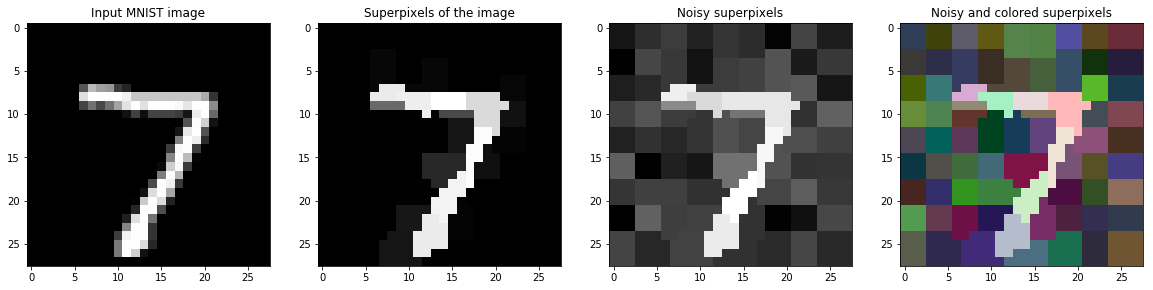

1000/10000, acc clean=96.20%, acc noise=87.10%, acc color noise=91.10%
2000/10000, acc clean=95.05%, acc noise=86.00%, acc color noise=88.90%
3000/10000, acc clean=94.87%, acc noise=85.53%, acc color noise=88.10%
4000/10000, acc clean=94.57%, acc noise=85.03%, acc color noise=87.98%
5000/10000, acc clean=94.66%, acc noise=85.00%, acc color noise=88.20%
6000/10000, acc clean=95.15%, acc noise=86.27%, acc color noise=89.33%
7000/10000, acc clean=95.56%, acc noise=87.06%, acc color noise=89.97%
8000/10000, acc clean=96.00%, acc noise=87.64%, acc color noise=90.34%
9000/10000, acc clean=96.27%, acc noise=88.23%, acc color noise=90.92%
10000/10000, acc clean=96.22%, acc noise=88.20%, acc color noise=90.87%


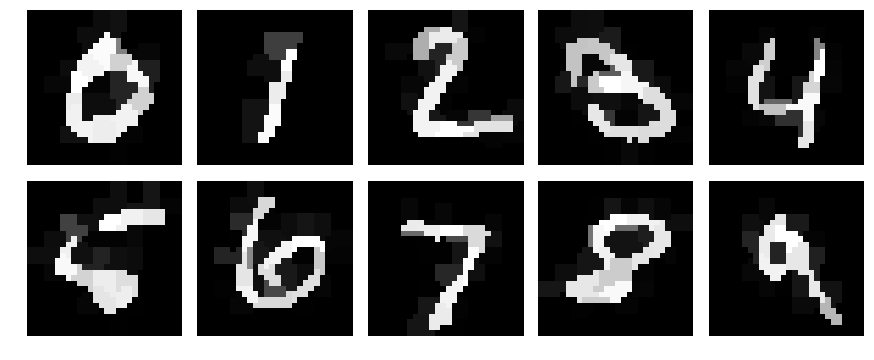

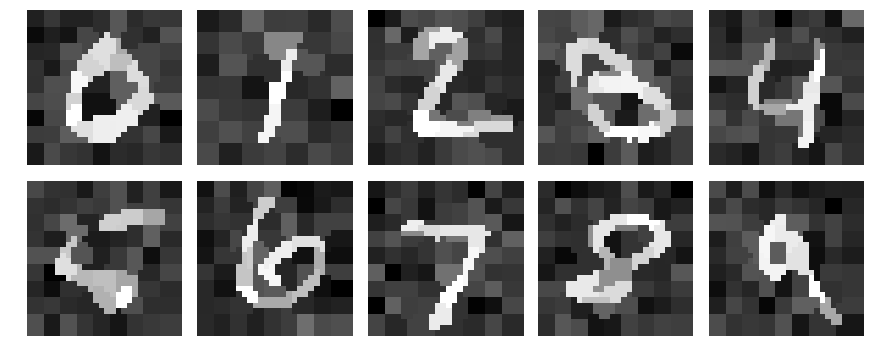

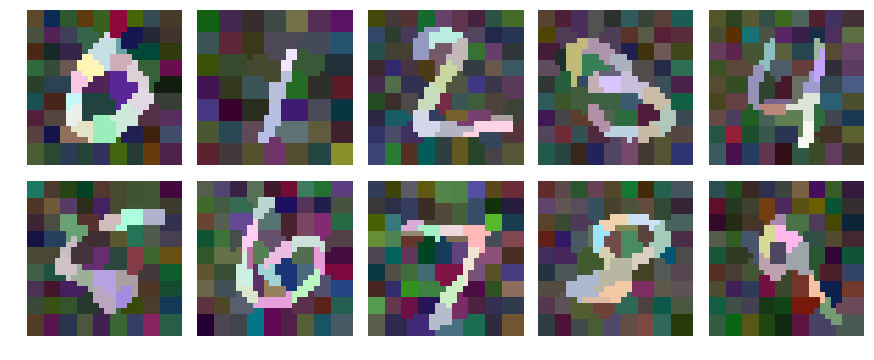

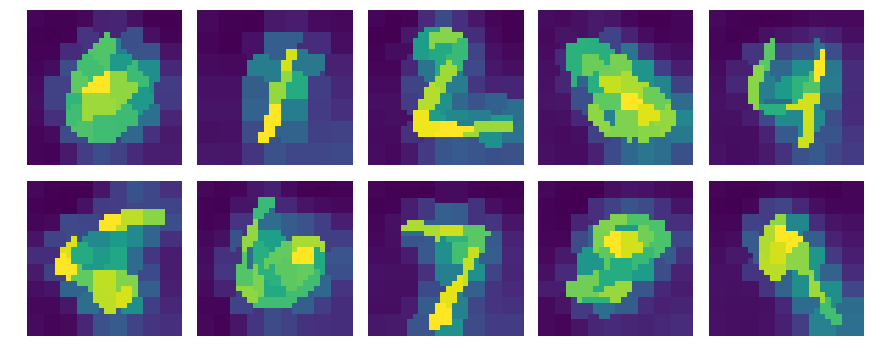

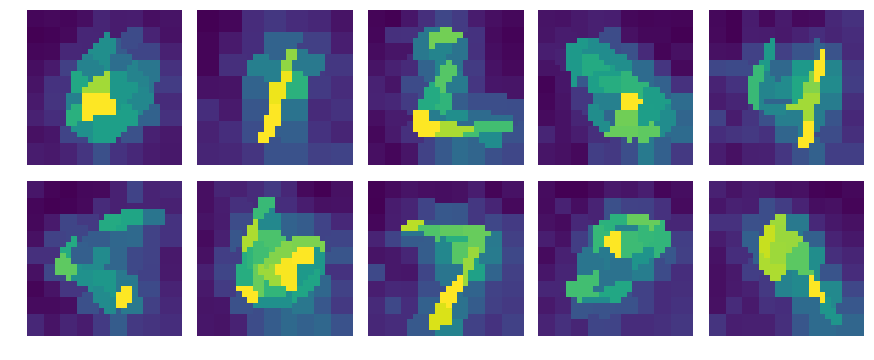

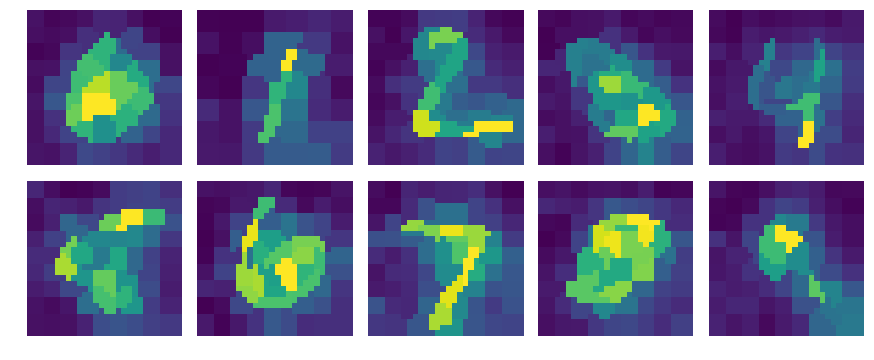

In [7]:
pred, pred_noise, pred_colornoise, alpha, alpha_noise, alpha_colornoise = get_predictions('%s/checkpoint_mnist-75sp_065802_epoch30_seed0000111.pth.tar' % checkpoints_dir)
visualize(alpha, alpha_noise, alpha_colornoise)

## Unsupervised attention model

ChebyGINLayer torch.Size([4, 20]) tensor([0.5779, 0.5174, 0.5733, 0.6026], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.6162, 0.5194, 0.5796, 0.5341, 0.5867, 0.5972, 0.5684, 0.4639, 0.5436,
        0.5333], grad_fn=<SliceBackward>)
p values [-0.28535885  0.44539523  0.861483    1.0510575 ]
cos_sim 0.4405839741230011
ChebyGINLayer torch.Size([512, 256]) tensor([0.5932, 0.5888, 0.5660, 0.5865, 0.5767, 0.5828, 0.5894, 0.5534, 0.5465,
        0.5549], grad_fn=<SliceBackward>)


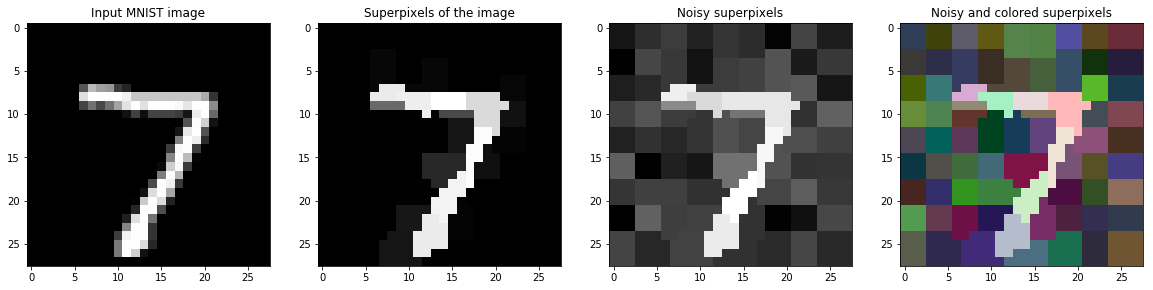

1000/10000, acc clean=96.30%, acc noise=90.50%, acc color noise=92.10%
2000/10000, acc clean=95.35%, acc noise=89.95%, acc color noise=91.30%
3000/10000, acc clean=95.07%, acc noise=89.40%, acc color noise=91.23%
4000/10000, acc clean=94.90%, acc noise=89.28%, acc color noise=91.20%
5000/10000, acc clean=94.88%, acc noise=89.16%, acc color noise=91.20%
6000/10000, acc clean=95.27%, acc noise=89.97%, acc color noise=91.73%
7000/10000, acc clean=95.67%, acc noise=90.56%, acc color noise=92.20%
8000/10000, acc clean=96.07%, acc noise=91.06%, acc color noise=92.69%
9000/10000, acc clean=96.36%, acc noise=91.64%, acc color noise=93.24%
10000/10000, acc clean=96.34%, acc noise=91.66%, acc color noise=93.19%


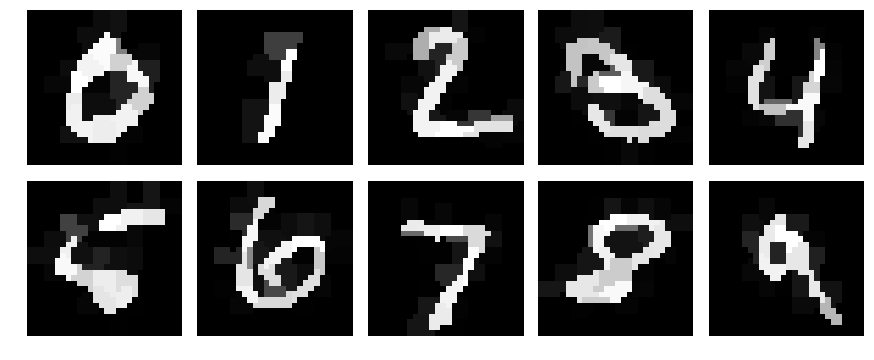

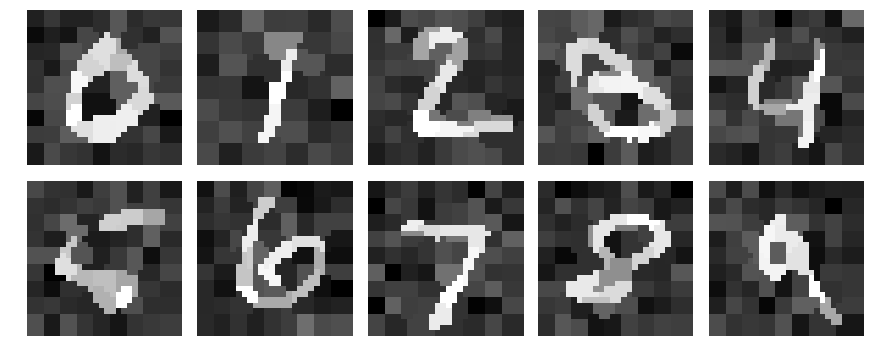

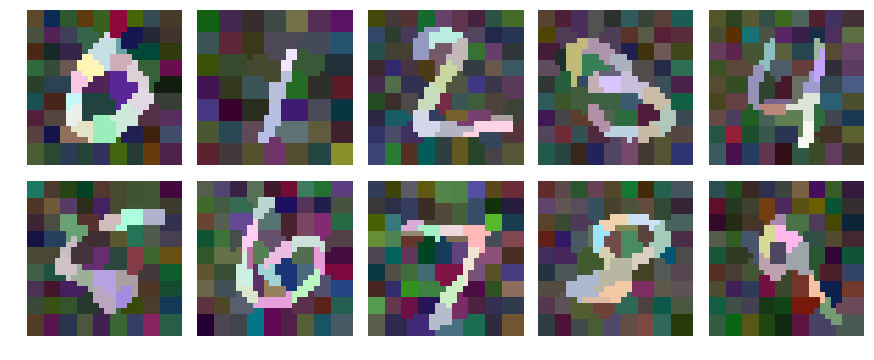

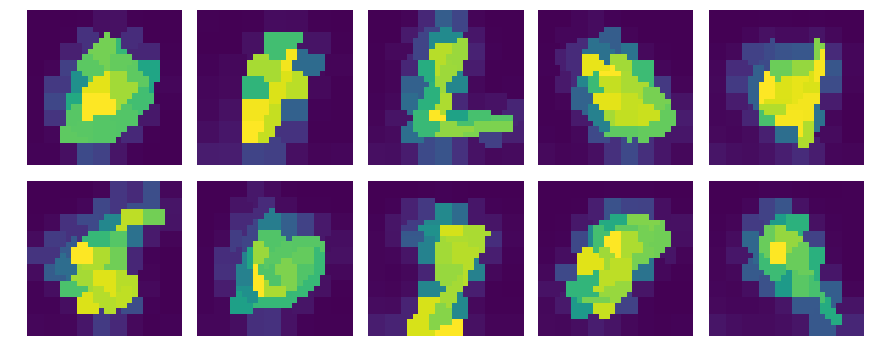

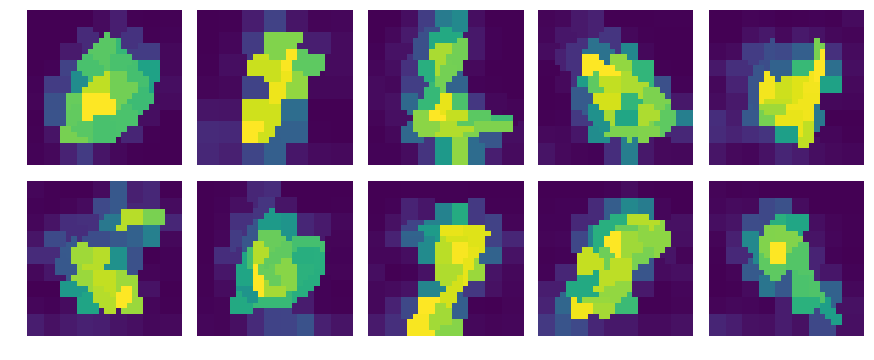

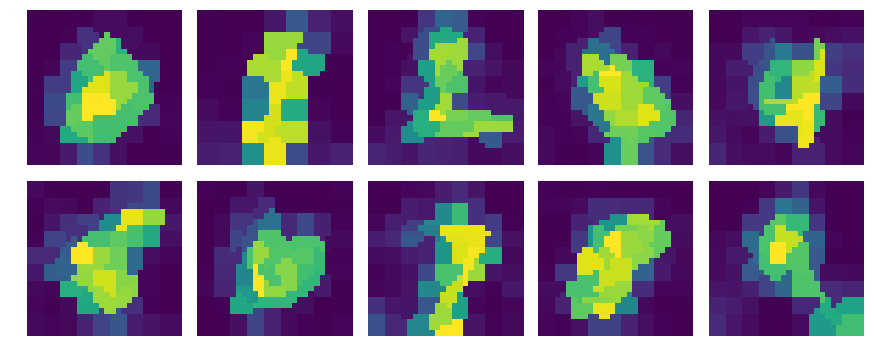

In [8]:
pred, pred_noise, pred_colornoise, alpha, alpha_noise, alpha_colornoise = get_predictions('%s/checkpoint_mnist-75sp_330394_epoch30_seed0000111.pth.tar' % checkpoints_dir)
visualize(alpha, alpha_noise, alpha_colornoise)

## Supervised attention model

ChebyGINLayer torch.Size([4, 20]) tensor([0.5976, 0.5982, 0.5489, 0.5821], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 16]) tensor([0.5029, 0.5401, 0.6651, 0.5777, 0.5955, 0.6611, 0.5086, 0.6057, 0.6270,
        0.6079], grad_fn=<SliceBackward>)
p values [ 1.0986348  -0.09890237 -0.1367538  -0.6791957 ]
cos_sim -0.08897919952869415
ChebyGINLayer torch.Size([512, 256]) tensor([0.5758, 0.6058, 0.5730, 0.5744, 0.6097, 0.5795, 0.5398, 0.5714, 0.5727,
        0.5993], grad_fn=<SliceBackward>)


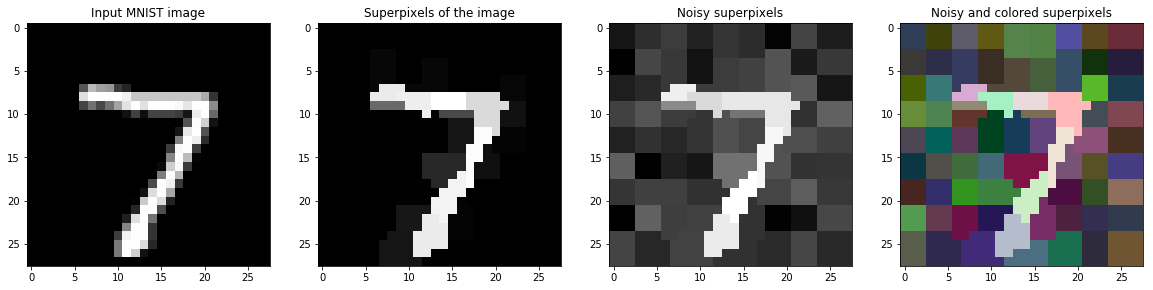

1000/10000, acc clean=96.20%, acc noise=87.60%, acc color noise=91.60%
2000/10000, acc clean=94.50%, acc noise=86.50%, acc color noise=90.05%
3000/10000, acc clean=93.93%, acc noise=86.47%, acc color noise=89.50%
4000/10000, acc clean=93.70%, acc noise=87.35%, acc color noise=89.88%
5000/10000, acc clean=93.72%, acc noise=87.82%, acc color noise=89.98%
6000/10000, acc clean=94.25%, acc noise=88.67%, acc color noise=90.72%
7000/10000, acc clean=94.70%, acc noise=89.19%, acc color noise=91.23%
8000/10000, acc clean=95.17%, acc noise=89.72%, acc color noise=91.79%
9000/10000, acc clean=95.60%, acc noise=90.32%, acc color noise=92.38%
10000/10000, acc clean=95.66%, acc noise=90.40%, acc color noise=92.41%


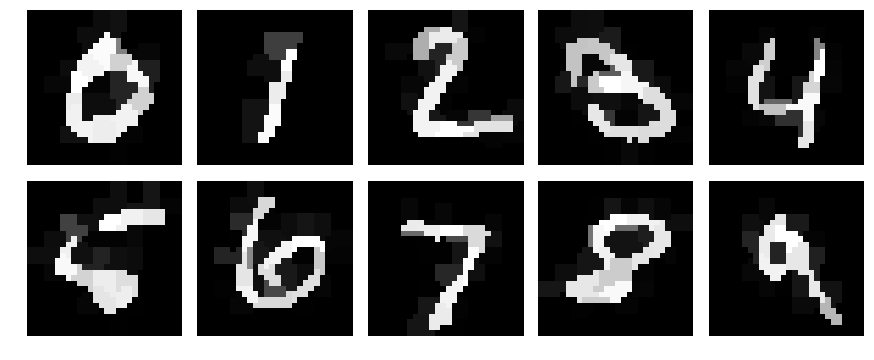

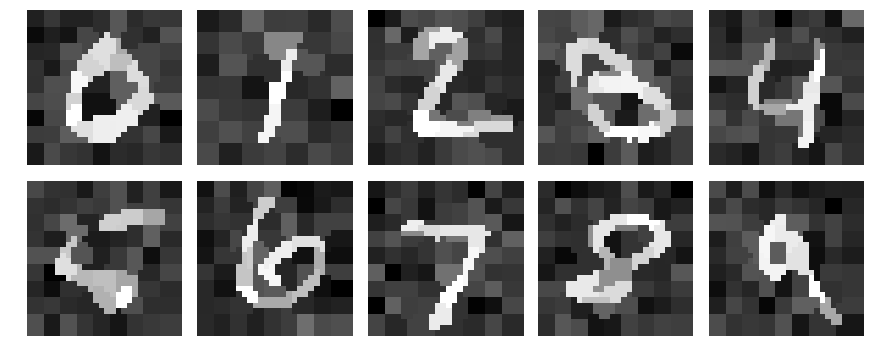

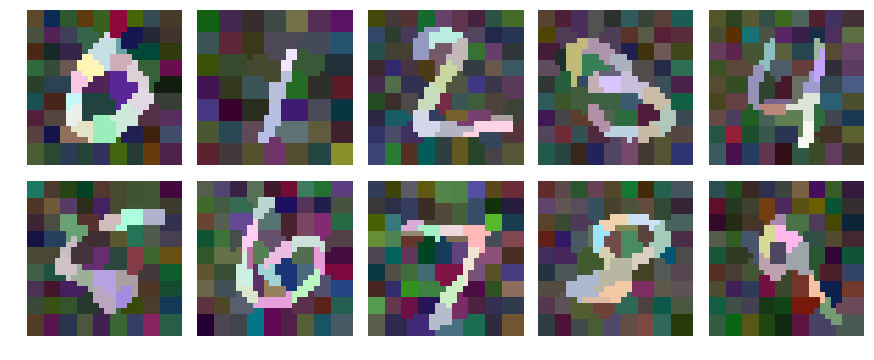

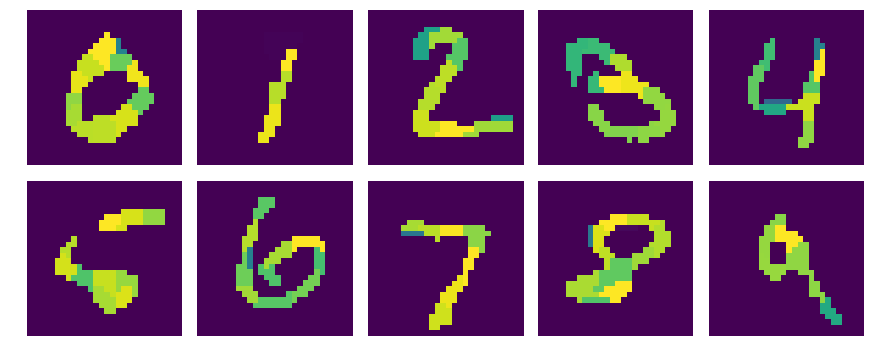

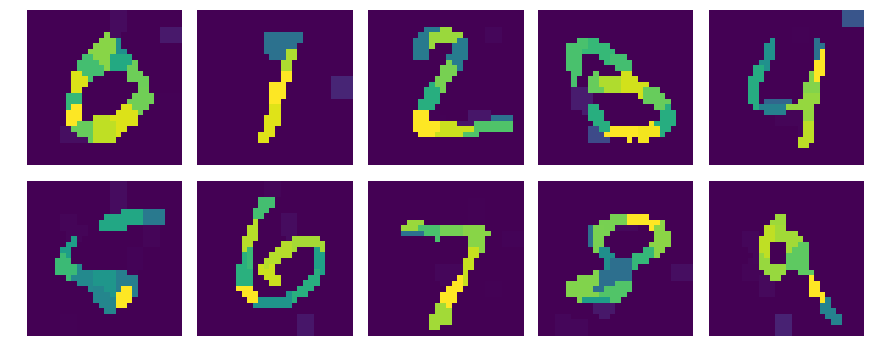

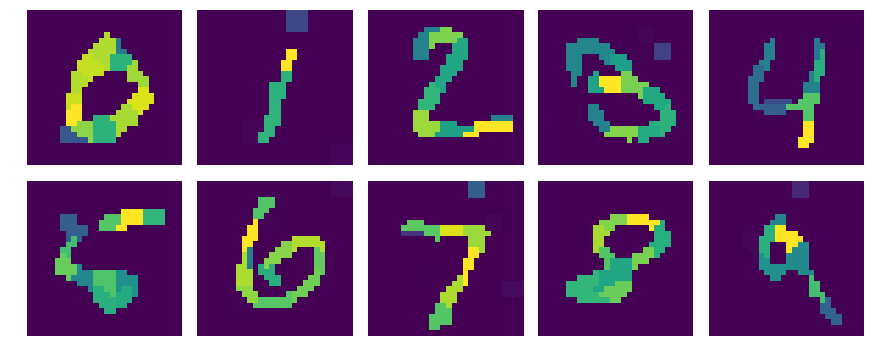

In [9]:
pred, pred_noise, pred_colornoise, alpha, alpha_noise, alpha_colornoise = get_predictions('%s/checkpoint_mnist-75sp_139255_epoch30_seed0000111.pth.tar' % checkpoints_dir)
visualize(alpha, alpha_noise, alpha_colornoise)